In [16]:
import pandas as pd
import plotly.plotly as pyl
import plotly.graph_objs as go
import matplotlib.pyplot as plt

%matplotlib inline 

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [17]:
df_logs = pd.read_parquet("../data/logs.parquet")
df_loc = pd.read_parquet("../data/loc.parquet")
df_tops = pd.read_parquet("../data/tops.parquet")

TOPS = ['MARCEL', 'CONRAD', 'SYLVAIN']

In [62]:
df_logs.head()

,wellName,DEPTH,GR
1,512320698.0,421.0,96.9752
2,512320698.0,421.5,102.3324
3,512320698.0,422.0,104.6432
4,512320698.0,422.5,99.2187
5,512320698.0,423.0,92.0200


# Data cleaning

In [66]:
# Consistency check: df_tops df_logs
fail_list = set()
for wellname in df_tops.index.to_list():
    for topname in TOPS:
        df_temp = df_logs[df_logs["wellName"] == wellname]
        true_top = df_tops.loc[wellname][topname] 
        if true_top > 0:    
            if len(df_temp[df_temp["DEPTH"] == true_top]) == 0:
                # print(f'well({wellname} top({topname}) consistency check fails')
                fail_list.add(wellname)

# 10
print(len(fail_list), 'to be removed')
df_tops_cleaned = df_tops.drop(fail_list)
print(len(df_tops_cleaned), 'left')

10 to be removed
590 left


In [67]:
# Consistency check: df_tops df_loc
fail_list = set()
for wellname in df_tops.index.to_list():
    if wellname not in df_loc.index:
        fail_list.add(wellname)
# 0
print(len(fail_list), 'to be removed')
df_tops_cleaned = df_tops_cleaned.drop(fail_list)
print(len(df_tops_cleaned), 'left')

0 to be removed
590 left


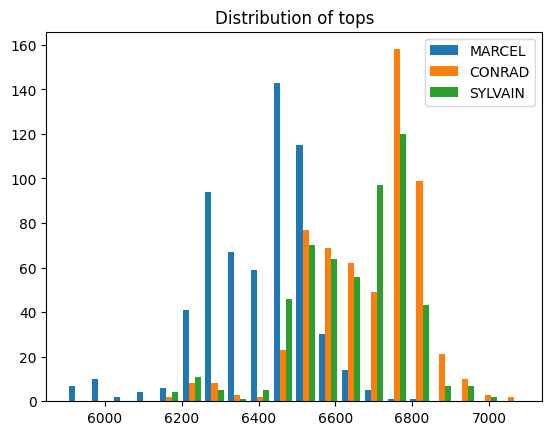

In [68]:
fig, axes = plt.subplots()
axes.hist(df_tops[TOPS], bins=20, label=TOPS)
axes.legend(prop={'size': 10})
axes.set_title("Distribution of tops")
plt.show()

# Baseline model

In [70]:
TOP = 'MARCEL'
WINDOW_SIZE = 200   # samples

def extract_top(wellname, topname):
    return df_tops_cleaned.loc[wellname][topname]

def extract_window(wellname, topname, window_size):
    df_temp = df_logs[df_logs["wellName"] == wellname]
    true_top = extract_top(wellname, topname)
    if true_top > 0:
        # the index of log corresponding to top depth
        # print(wellname,true_top)
        # print('---',df_temp[df_temp["DEPTH"] == true_top])
        ctr = df_temp[df_temp["DEPTH"] == true_top].index[0]
        from_idx = max(df_temp.index[0], ctr - window_size/2)
        to_idx = min(df_temp.index[-1], ctr + window_size/2)
        window = df_temp.loc[from_idx : to_idx]
        return window
    return None

X = list()
Y = list()
wellist = df_tops_cleaned.index.tolist()
for wellname in wellist: 
    window = extract_window(wellname, TOP, WINDOW_SIZE)
    if window is not None:
        X.append(window) 

# todo: 

[          wellName   DEPTH        GR
 11855  512320698.0  6348.0  153.0544
 11856  512320698.0  6348.5  157.8600
 11857  512320698.0  6349.0  164.4784
 11858  512320698.0  6349.5  171.2071
 11859  512320698.0  6350.0  172.3648
 ...            ...     ...       ...
 12051  512320698.0  6446.0  153.9684
 12052  512320698.0  6446.5  153.0621
 12053  512320698.0  6447.0  152.6014
 12054  512320698.0  6447.5  154.6994
 12055  512320698.0  6448.0  156.2884
 
 [201 rows x 3 columns],
           wellName   DEPTH        GR
 24647  512320699.0  6357.0  134.1998
 24648  512320699.0  6357.5  139.8711
 24649  512320699.0  6358.0  141.5701
 24650  512320699.0  6358.5  142.7945
 24651  512320699.0  6359.0  143.1076
 ...            ...     ...       ...
 24843  512320699.0  6455.0  167.6961
 24844  512320699.0  6455.5  171.6439
 24845  512320699.0  6456.0  177.5152
 24846  512320699.0  6456.5  179.0608
 24847  512320699.0  6457.0  174.1523
 
 [201 rows x 3 columns],
           wellName   DEPTH       

Only consider MARCEL top.

A naive approach1:
- Given a new ts object T1, find the closest object T2 with label using DTW distance
- Use the DTW mapping find the depth of MARCEL in T1

Result:
- Very slow to calculate DTW. 50 secs for one instance
- Not scalable at all

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)
print('train size', len(X_train))
print('test size', len(X_test))

for i, x_test in enumerate(X_test[0:1]):
    min_idx = 0
    min_dtw_dist = -1
    # find the closest one based on DTW distance
    for j, x_train in enumerate(X_train):
        print(f'comparing{j}')
        dtw_dist = dtw(x_test['GR'], x_train['GR'])
        if min_dtw_dist < 0 or dtw_dist < min_dtw_dist:
             min_dtw_dist = dtw_dist
             min_idx = j
    closest = X_train[min_idx]
    print(min_idx, min_dtw_dist)
    print(closest)


train size 402
test size 198
comparing0
comparing1
comparing2
comparing3
comparing4


KeyboardInterrupt: 